In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\felicia\appdata\local\temp\pip-req-build-hy_qrf_i
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\felicia\AppData\Local\Temp\pip-req-build-hy_qrf_i'


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

import clip

clip.available_models()

Torch version: 2.2.1+cu118


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#model, preprocess = clip.load("ViT-B/32", device)
model, preprocess = clip.load("RN101", device)
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 278M/278M [19:22<00:00, 251kiB/s]


Model parameters: 119,688,033
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
import pathlib
dataset_root_path = pathlib.Path('datasets/UCF101/UCF-101')

all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("test_seen/*/*.avi"))
    + list(dataset_root_path.glob("test_unseen/*/*.avi"))
)
all_video_file_paths[:5]

class_labels = sorted({str(path).split("\\")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"{len(class_labels)} Unique classes: {class_labels}.")

51 Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BasketballDunk', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BrushingTeeth', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'Haircut', 'HammerThrow', 'Hammering', 'HandStandPushups', 'HandstandWalking', 'HeadMassage', 'IceDancing', 'Knitting', 'LongJump', 'MoppingFloor', 'ParallelBars', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingSitar', 'Rafting', 'ShavingBeard', 'Shotput', 'SkyDiving', 'SoccerPenalty', 'StillRings', 'SumoWrestling', 'Surfing', 'TableTennisShot', 'Typing', 'UnevenBars', 'WallPushups', 'WritingOnBoard'].


In [27]:
# map seen unseen classes id to all

seen_labels = sorted({str(path).split("\\")[-2] for path in list(dataset_root_path.glob("test_seen/*/*.avi"))})
seen_label2id = {label: i for i, label in enumerate(seen_labels)}
seen_id2label = {i: label for label, i in seen_label2id.items()}


unseen_labels = sorted({str(path).split("\\")[-2] for path in list(dataset_root_path.glob("test_unseen/*/*.avi"))})
unseen_label2id = {label: i for i, label in enumerate(unseen_labels)}
unseen_id2label = {i: label for label, i in unseen_label2id.items()}

seen_id2all_id = {i: label2id[label] for i, label in seen_id2label.items()}
unseen_id2all_id = {i: label2id[label] for i, label in unseen_id2label.items()}


In [28]:
print(unseen_id2all_id)
print('ALL', id2label)
print('unseen', unseen_id2label)

ids = torch.tensor([0, 0, 2])

mapped_ids = torch.zeros(ids.shape)
for i in range(ids.shape[0]):
    val = ids[i].item()
    mapped_ids[i] = unseen_id2all_id[val]

print(mapped_ids)

{0: 5, 1: 7, 2: 13, 3: 17, 4: 36, 5: 37, 6: 39, 7: 47, 8: 50}
ALL {0: 'ApplyEyeMakeup', 1: 'ApplyLipstick', 2: 'Archery', 3: 'BabyCrawling', 4: 'BalanceBeam', 5: 'BandMarching', 6: 'BasketballDunk', 7: 'BlowDryHair', 8: 'BlowingCandles', 9: 'BodyWeightSquats', 10: 'Bowling', 11: 'BoxingPunchingBag', 12: 'BoxingSpeedBag', 13: 'BrushingTeeth', 14: 'CliffDiving', 15: 'CricketBowling', 16: 'CricketShot', 17: 'CuttingInKitchen', 18: 'FieldHockeyPenalty', 19: 'FloorGymnastics', 20: 'FrisbeeCatch', 21: 'FrontCrawl', 22: 'Haircut', 23: 'HammerThrow', 24: 'Hammering', 25: 'HandStandPushups', 26: 'HandstandWalking', 27: 'HeadMassage', 28: 'IceDancing', 29: 'Knitting', 30: 'LongJump', 31: 'MoppingFloor', 32: 'ParallelBars', 33: 'PlayingCello', 34: 'PlayingDaf', 35: 'PlayingDhol', 36: 'PlayingFlute', 37: 'PlayingSitar', 38: 'Rafting', 39: 'ShavingBeard', 40: 'Shotput', 41: 'SkyDiving', 42: 'SoccerPenalty', 43: 'StillRings', 44: 'SumoWrestling', 45: 'Surfing', 46: 'TableTennisShot', 47: 'Typing', 4

In [5]:
clip_templates = {
    'ApplyEyeMakeup': 'A person applying eye makeup carefully with brushes and cosmetics.',
    'ApplyLipstick': 'An individual applying lipstick, focusing on the details of the lips.',
    'Archery': 'A person holding a bow and aiming an arrow in an archery stance.',
    'BabyCrawling': 'A baby crawling on the floor, moving forward on hands and knees.',
    'BalanceBeam': 'An athlete performing on a balance beam, displaying agility and balance.',
    'BandMarching': 'A marching band moving in formation while playing instruments.',
    'BasketballDunk': 'A basketball player performing a dunk, leaping high towards the basket.',
    'BlowDryHair': 'Someone blow drying hair, using a hairdryer to style it.',
    'BlowingCandles': 'A person blowing out candles on a cake, possibly making a wish.',
    'BodyWeightSquats': 'An individual doing body weight squats, showing exercise and fitness.',
    'Bowling': 'A bowler throwing a bowling ball down a lane towards pins.',
    'BoxingPunchingBag': 'A boxer practicing punches on a punching bag.',
    'BoxingSpeedBag': 'A boxer training with a speed bag, improving hand-eye coordination.',
    'BrushingTeeth': 'A person brushing their teeth with a toothbrush and toothpaste.',
    'CliffDiving': 'An adventurer cliff diving into water from a high cliff.',
    'CricketBowling': 'A cricket bowler in action, delivering the ball to the batsman.',
    'CricketShot': 'A cricket batsman playing a shot with the cricket bat.',
    'CuttingInKitchen': 'Someone cutting vegetables or ingredients in a kitchen setting.',
    'FieldHockeyPenalty': 'A field hockey player taking a penalty shot at goal.',
    'FloorGymnastics': 'A gymnast performing floor gymnastics, showing flexibility and strength.',
    'FrisbeeCatch': 'A person catching a frisbee, showcasing agility and timing.',
    'FrontCrawl': 'A swimmer doing the front crawl stroke in a pool.',
    'Haircut': 'A professional giving a haircut to a client, using scissors and combs.',
    'HammerThrow': 'An athlete throwing a hammer in a hammer throw competition.',
    'Hammering': 'A person hammering a nail into wood or a similar surface.',
    'HandStandPushups': 'An individual doing handstand pushups, showing strength and balance.',
    'HandstandWalking': 'Someone walking on their hands, maintaining a handstand position.',
    'HeadMassage': 'A person receiving a relaxing head massage.',
    'IceDancing': 'Ice dancers performing a routine on an ice rink with grace and skill.',
    'Knitting': 'An individual knitting with yarn and needles, creating a textile.',
    'LongJump': 'An athlete performing a long jump, leaping into the sand pit.',
    'MoppingFloor': 'Someone mopping a floor, cleaning it with a mop and bucket.',
    'ParallelBars': 'A gymnast performing a routine on the parallel bars.',
    'PlayingCello': 'A musician playing the cello, using a bow on the strings.',
    'PlayingDaf': 'A person playing the daf, a type of frame drum.',
    'PlayingDhol': 'An individual playing the dhol, a traditional drum.',
    'PlayingFlute': 'A flutist playing the flute, producing melodious music.',
    'PlayingSitar': 'A musician playing the sitar, an Indian stringed instrument.',
    'Rafting': 'Adventurers rafting down a river, navigating rapids and waves.',
    'ShavingBeard': 'A person shaving their beard with a razor or electric shaver.',
    'Shotput': 'An athlete throwing a shot put in a track and field event.',
    'SkyDiving': 'A skydiver free falling or parachuting from high altitude.',
    'SoccerPenalty': 'A soccer player taking a penalty kick at goal.',
    'StillRings': 'A gymnast performing on the still rings, showing strength and control.',
    'SumoWrestling': 'Sumo wrestlers engaging in a match, showcasing power and technique.',
    'Surfing': 'A surfer riding a wave on a surfboard, displaying balance and skill.',
    'TableTennisShot': 'A player making a shot in table tennis, showing speed and precision.',
    'Typing': 'Someone typing on a keyboard, their fingers moving swiftly across the keys.',
    'UnevenBars': 'A gymnast performing a routine on the uneven bars, demonstrating agility and grace.',
    'WallPushups': 'An individual doing wall pushups, using a wall for resistance training.',
    'WritingOnBoard': 'A person writing on a board with a marker or chalk, conveying information.'
    }

In [36]:
import pytorchvideo.data
import torchvision

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

def _normalization(x):
    return x/255.0

def _permute(x):
    return x.permute(1, 0, 2, 3)


train_transform=Compose(
                [
                    # UniformTemporalSubsample(16),
                    Lambda(_permute),
                    Lambda(_normalization),
                    Normalize(0.5, 0.5),
                    Resize((224, 224)),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop((224, 224)),
                    RandomHorizontalFlip(p=0.5),
                ]
            )


test_transform=Compose(
                [
                    # UniformTemporalSubsample(16),
                    Lambda(_permute),
                    Lambda(_normalization),
                    Normalize(0.5, 0.5),
                    Resize((224, 224)),
                ]
            )


train_dataset = torchvision.datasets.UCF101(
    root="datasets/UCF101/UCF-101/train", annotation_path="datasets/UCF101/UCF101TrainTestSplits-Kaggle/ucfTrainTestlist",
    frames_per_clip=1, step_between_clips=64, train=True, num_workers=12, output_format = "TCHW", transform=train_transform
)



test_seen_dataset = torchvision.datasets.UCF101(
    root="datasets/UCF101/UCF-101/test_seen", annotation_path="datasets/UCF101/UCF101TrainTestSplits-Kaggle/ucfTrainTestlist",
    frames_per_clip=1, step_between_clips=16, train=False,num_workers=12,output_format = "TCHW", transform=test_transform
)

test_unseen_dataset = torchvision.datasets.UCF101(
    root="datasets/UCF101/UCF-101/test_unseen", annotation_path="datasets/UCF101/UCF101TrainTestSplits-Kaggle/ucfTrainTestlist",
    frames_per_clip=1, step_between_clips=16, train=False, num_workers=12,output_format = "TCHW", transform=test_transform
)

100%|██████████| 80/80 [00:22<00:00,  3.48it/s]


In [6]:
print(len(test_seen_dataset.classes), len(test_unseen_dataset.classes))

42 9


c:\Users\felicia\.conda\envs\mmml\lib\site-packages\torchvision\io\video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


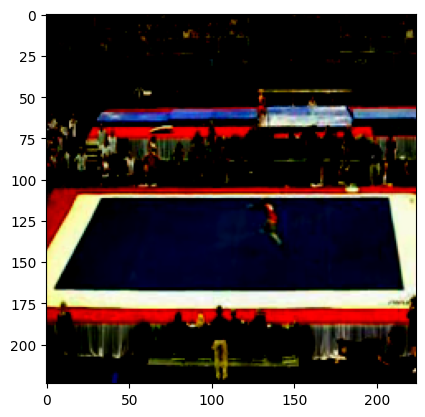

FloorGymnastics


In [7]:
import matplotlib.pyplot as plt

index = 534

plt.imshow(test_seen_dataset[index][0].squeeze(1).permute(1, 2, 0))
plt.show()

print(test_seen_dataset.classes[test_seen_dataset[index][2]])

In [8]:
def custom_collate(batch):
    filtered_batch = []
    for video, _, label in batch:
        filtered_batch.append((video, label))
    return torch.utils.data.dataloader.default_collate(filtered_batch)

test_seen_loader = torch.utils.data.DataLoader(test_seen_dataset, batch_size=512, shuffle=False, collate_fn=custom_collate)
test_unseen_loader = torch.utils.data.DataLoader(test_unseen_dataset, batch_size=512, shuffle=False, collate_fn=custom_collate)

In [33]:
from tqdm.notebook import tqdm




def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
     


def inference(model, dataset, loader, all_class_labels, id_mapping):
    top1, top3, top5 = 0, 0, 0
    for inputs, labels in tqdm(loader, total=len(loader), leave=False):

        image_input = inputs.squeeze(2).to(device)
        labels = labels.to(device)

    
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}")for c in all_class_labels]).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # map current dataset class id to all class id
        mapped_labels = torch.zeros(labels.shape).to(device)
        for i in range(labels.shape[0]):
            val = labels[i].item()
            mapped_labels[i] = id_mapping[val]
        
        acc1, acc3, acc5 = accuracy(similarity, mapped_labels, topk=(1, 3, 5))
        top1 += acc1
        top3 += acc3
        top5 += acc5

        


        #correct += (indices.flatten() == labels).sum().item()

    return top1/len(dataset), top1, top3/len(dataset), top3, top5/len(dataset), top5


    
    

    




In [34]:

top1_acc, top1, top3_acc, top3, top5_acc, top5 = inference(model, test_seen_dataset, test_seen_loader, class_labels, seen_id2all_id)
print("test_seen_dataset")
print(f"Top-1 accuracy: {top1_acc:.3%}, correct: {int(top1)}/{len(test_seen_dataset)}")
print(f"Top-3 accuracy: {top3_acc:.3%}, correct: {int(top3)}/{len(test_seen_dataset)}")
print(f"Top-5 accuracy: {top5_acc:.3%}, correct: {int(top5)}/{len(test_seen_dataset)}")


top1_acc, top1, top3_acc, top3, top5_acc, top5 = inference(model, test_unseen_dataset, test_unseen_loader, class_labels, unseen_id2all_id)
print("test_unseen_dataset")
print(f"Top-1 accuracy: {top1_acc:.3%}, correct: {int(top1)}/{len(test_unseen_dataset)}")
print(f"Top-3 accuracy: {top3_acc:.3%}, correct: {int(top3)}/{len(test_unseen_dataset)}")
print(f"Top-5 accuracy: {top5_acc:.3%}, correct: {int(top5)}/{len(test_unseen_dataset)}")

  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\felicia\.conda\envs\mmml\lib\site-packages\torchvision\io\video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


test_seen_dataset
Top-1 accuracy: 56.780%, correct: 871/1534
Top-3 accuracy: 77.379%, correct: 1187/1534
Top-5 accuracy: 83.377%, correct: 1279/1534


  0%|          | 0/11 [00:00<?, ?it/s]

test_unseen_dataset
Top-1 accuracy: 77.615%, correct: 4074/5249
Top-3 accuracy: 88.303%, correct: 4635/5249
Top-5 accuracy: 90.913%, correct: 4772/5249


In [37]:
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

EPOCH = 10
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, collate_fn=custom_collate)

#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

if device == "cpu":
    model.float()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader)*EPOCH)


In [38]:
best_te_loss = 1e5
best_ep = -1
losses = []
for epoch in range(EPOCH):
    step = 0
    tr_loss = 0
    model.train()
    pbar = tqdm(train_loader, leave=False)
    for batch in pbar:
        step += 1
        optimizer.zero_grad()

        images, texts = batch
        images = images.squeeze(2).to(device)


        text_input = torch.cat([clip.tokenize(f"a photo of a {train_dataset.classes[c]}")for c in texts]).to(device)

        logits_per_image, logits_per_text = model(images, text_input)
        ground_truth = torch.arange(len(images)).to(device)

        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth))/2
        total_loss.backward()
        losses.append(total_loss.item())
        tr_loss += total_loss.item()
        if device == "cpu":
            optimizer.step()
            scheduler.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            scheduler.step()
            clip.model.convert_weights(model)
        pbar.set_description(f"train batchCE: {total_loss.item()}", refresh=True)
    tr_loss /= step
    
    step = 0
    te_loss = 0
    with torch.no_grad():
        model.eval()
        test_pbar = tqdm(test_seen_loader, leave=False)
        for batch in test_pbar:
            step += 1
            images, texts = batch
            images = images.squeeze(2).to(device)
            text_input = torch.cat([clip.tokenize(f"a photo of a {test_seen_dataset.classes[c]}")for c in texts]).to(device)
            logits_per_image, logits_per_text = model(images, text_input)
            ground_truth = torch.arange(len(images)).to(device)

            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            te_loss += total_loss.item()
            test_pbar.set_description(f"test batchCE: {total_loss.item()}", refresh=True)
        te_loss /= step
        
    print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")

  0%|          | 0/84 [00:00<?, ?it/s]

c:\Users\felicia\.conda\envs\mmml\lib\site-packages\torchvision\io\video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0, tr_loss 4.961542038690476, te_loss 5.8671875


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 1, tr_loss 4.828078497023809, te_loss 5.674479166666667


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 2, tr_loss 4.791620163690476, te_loss 5.53125


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 3, tr_loss 4.770042782738095, te_loss 5.463541666666667


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 4, tr_loss 4.748372395833333, te_loss 5.479166666666667


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 5, tr_loss 4.735770089285714, te_loss 5.38671875


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 6, tr_loss 4.728608630952381, te_loss 5.384114583333333


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 7, tr_loss 4.726981026785714, te_loss 5.385416666666667


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 8, tr_loss 4.7253534226190474, te_loss 5.385416666666667


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 9, tr_loss 4.724934895833333, te_loss 5.384114583333333


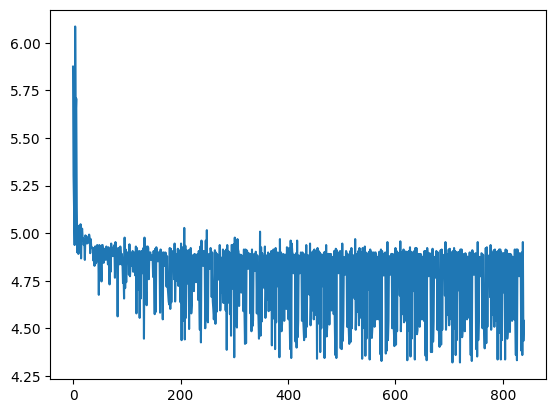

In [39]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [40]:
model.eval()

top1_acc, top1, top3_acc, top3, top5_acc, top5 = inference(model, test_seen_dataset, test_seen_loader, class_labels, seen_id2all_id)
print("test_seen_dataset")
print(f"Top-1 accuracy: {top1_acc:.3%}, correct: {int(top1)}/{len(test_seen_dataset)}")
print(f"Top-3 accuracy: {top3_acc:.3%}, correct: {int(top3)}/{len(test_seen_dataset)}")
print(f"Top-5 accuracy: {top5_acc:.3%}, correct: {int(top5)}/{len(test_seen_dataset)}")


top1_acc, top1, top3_acc, top3, top5_acc, top5 = inference(model, test_unseen_dataset, test_unseen_loader, class_labels, unseen_id2all_id)
print("test_unseen_dataset")
print(f"Top-1 accuracy: {top1_acc:.3%}, correct: {int(top1)}/{len(test_unseen_dataset)}")
print(f"Top-3 accuracy: {top3_acc:.3%}, correct: {int(top3)}/{len(test_unseen_dataset)}")
print(f"Top-5 accuracy: {top5_acc:.3%}, correct: {int(top5)}/{len(test_unseen_dataset)}")

  0%|          | 0/3 [00:00<?, ?it/s]

test_seen_dataset
Top-1 accuracy: 35.528%, correct: 545/1534
Top-3 accuracy: 58.866%, correct: 903/1534
Top-5 accuracy: 68.905%, correct: 1057/1534


  0%|          | 0/11 [00:00<?, ?it/s]

test_unseen_dataset
Top-1 accuracy: 46.542%, correct: 2443/5249
Top-3 accuracy: 67.918%, correct: 3565/5249
Top-5 accuracy: 76.167%, correct: 3998/5249
